<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/01_pytorch_workflow_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Exercise


In [ ]:
# Import necessary libraries
import torch
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Create a straight line dataset using the linear regression formula (`weight * X + bias`).
  * Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total.
  * Split the data into 80% training, 20% testing.
  * Plot the training and testing data so it becomes visual.

Your output of the below cell should look something like:
```
Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900])
y: tensor([0.9000, 0.9030, 0.9060, 0.9090, 0.9120, 0.9150, 0.9180, 0.9210, 0.9240,
        0.9270])
```

Of course the numbers in `X` and `y` may be different but ideally they're created using the linear regression formula.

In [ ]:
# Create the data parameters
weight = 0.3
bias = 0.9
# Make X and y using linear regression feature
X = torch.arange(0,1,0.01).unsqueeze(dim=1)
y = weight * X + bias
print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
y: tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]])


In [ ]:
# Split the data into training and testing
train_split = int(len(X) * 0.8)
X_train = X[:train_split]
X_test = X[train_split:]
y_train = y[:train_split]
y_test = y[train_split:]
len(X_train),len(y_train),len(X_test),len(X_test)

(80, 80, 20, 20)

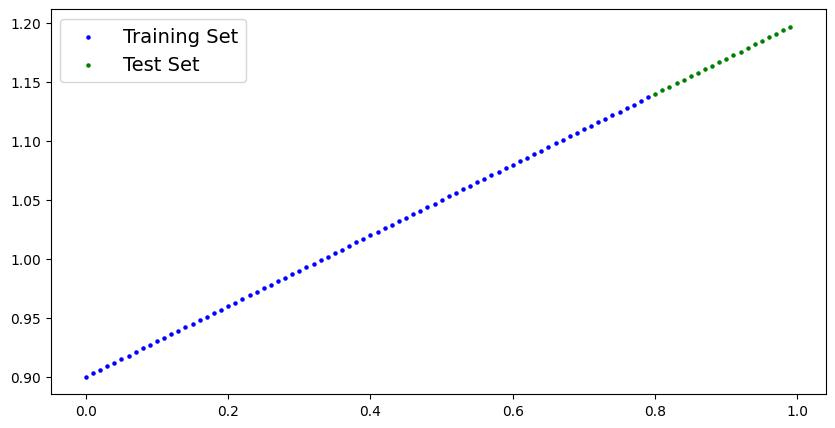

In [ ]:
# Plot the training and testing data
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None
                    ):
  plt.figure(figsize = (10,5))
  plt.scatter(train_data,train_labels,c="b",s=5,label="Training Set")
  plt.scatter(test_data,test_labels,c="g",s=5,label="Test Set")

  if predictions is not None:
    plt.scatter(test_data,predictions,c="r",s=5,label="Predictions")
  plt.legend(prop = { "size" : 14})
plot_prediction()

## 2. Build a PyTorch model by subclassing `nn.Module`.
  * Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`.
  * Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
  * Once you've constructed the model, make an instance of it and check its `state_dict()`.
  * **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.

In [ ]:
# Create PyTorch linear regression model by subclassing nn.Module
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(15)
model_1 = LinearRegression()
model_1, model_1.state_dict()

(LinearRegression(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.4053]])),
              ('linear_layer.bias', tensor([-0.4468]))]))

In [ ]:
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Instantiate the model and put it to the target device
model_1.to(device)
list(model_1.parameters())

[Parameter containing:
 tensor([[-0.4053]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.4468], device='cuda:0', requires_grad=True)]

## 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.
  * Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  * Write a training loop to perform the appropriate training steps for 300 epochs.
  * The training loop should test the model on the test dataset every 20 epochs.

In [ ]:
# Create the loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01)

In [ ]:
# Training loop
torch.manual_seed(15)

# Train model for 300 epochs
epochs= 500

# Send data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Perform testing every 20 epochs
  if epoch % 20 == 0:

    # Put model in evaluation mode and setup inference context
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      y_preds = model_1(X_test)
      # 2. Calculate test loss
      test_loss = loss_fn(y_preds,y_test)
      # Print out what's happening
      print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}")

Epoch: 0 | Train loss: 0.008 | Test loss: 0.007
Epoch: 20 | Train loss: 0.008 | Test loss: 0.007
Epoch: 40 | Train loss: 0.008 | Test loss: 0.007
Epoch: 60 | Train loss: 0.008 | Test loss: 0.007
Epoch: 80 | Train loss: 0.008 | Test loss: 0.007
Epoch: 100 | Train loss: 0.008 | Test loss: 0.007
Epoch: 120 | Train loss: 0.008 | Test loss: 0.007
Epoch: 140 | Train loss: 0.008 | Test loss: 0.007
Epoch: 160 | Train loss: 0.008 | Test loss: 0.007
Epoch: 180 | Train loss: 0.008 | Test loss: 0.007
Epoch: 200 | Train loss: 0.008 | Test loss: 0.007
Epoch: 220 | Train loss: 0.008 | Test loss: 0.007
Epoch: 240 | Train loss: 0.008 | Test loss: 0.007
Epoch: 260 | Train loss: 0.008 | Test loss: 0.007
Epoch: 280 | Train loss: 0.008 | Test loss: 0.007
Epoch: 300 | Train loss: 0.008 | Test loss: 0.007
Epoch: 320 | Train loss: 0.008 | Test loss: 0.007
Epoch: 340 | Train loss: 0.008 | Test loss: 0.007
Epoch: 360 | Train loss: 0.008 | Test loss: 0.007
Epoch: 380 | Train loss: 0.008 | Test loss: 0.007
Epoch:

## 4. Make predictions with the trained model on the test data.
  * Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are *not* on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [ ]:
# Make predictions with the model
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[1.1468],
        [1.1497],
        [1.1527],
        [1.1557],
        [1.1586],
        [1.1616],
        [1.1646],
        [1.1676],
        [1.1705],
        [1.1735],
        [1.1765],
        [1.1795],
        [1.1824],
        [1.1854],
        [1.1884],
        [1.1913],
        [1.1943],
        [1.1973],
        [1.2003],
        [1.2032]], device='cuda:0')

In [ ]:
y_preds.cpu()[:10]

tensor([[1.1468],
        [1.1497],
        [1.1527],
        [1.1557],
        [1.1586],
        [1.1616],
        [1.1646],
        [1.1676],
        [1.1705],
        [1.1735]])

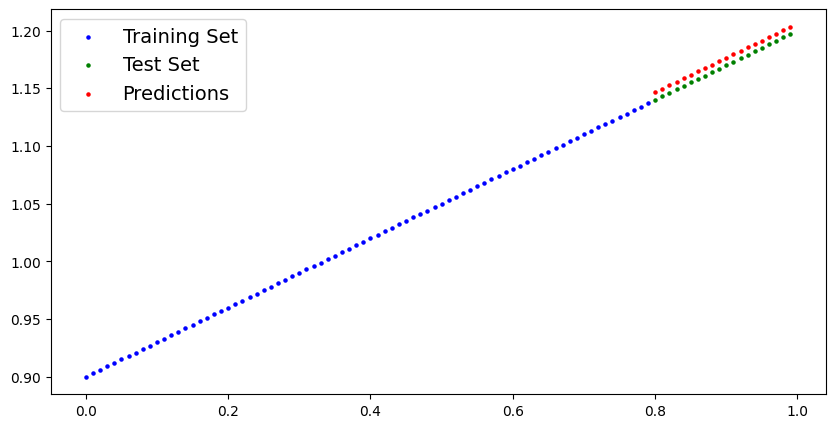

In [ ]:
# Plot the predictions (these may need to be on a specific device)
plot_prediction(predictions = y_preds.cpu())

## 5. Save your trained model's `state_dict()` to file.
  * Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "model-001"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
# 3. Save the model state dict
print(f"The model is being saved to {MODEL_PATH}")
torch.save(obj = model_1.state_dict(), f= MODEL_SAVE_PATH)

The model is being saved to models


In [ ]:
from torch.nn.modules.linear import Linear
# Create new instance of model and load saved state dict (make sure to put it on the target device)
loaded_model = LinearRegression()
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
loaded_model.to(device)

LinearRegression(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
# Make predictions with loaded model and compare them to the previous
y_preds_new = loaded_model(X_test)
y_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')